In [1]:
#Import libraries
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

import matplotlib.font_manager as font_manager
font_manager._get_fontconfig_fonts.cache_clear() # this is just to refresh the cache for fonts, maybe it's not even needed

In [4]:
## INPUTS for data processing
with_log = True # look at 'Preprocessing' section for further details
remove_outliers = False

data_checks = 'y'

In [13]:
# beautifiers
sns.set_style('whitegrid')#, {"font.family":['Optima']})
sns.set_context('talk', font_scale=2.5)

font = {'family' : 'Optima'}#,
#       'weight' : 'bold',
#       'size'   : 18}

unitocolor = '#EA0029'
unitogray  = '#54565A'
faircolor  = '#FDBB63'

# Create an array with the colors you want to use
colors = [unitocolor, unitogray]
# Set your custom color palette
unitopalette = sns.set_palette(sns.color_palette(colors))

# Read data using pandas

In [5]:
df_raw = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Z_boson.csv')
df_raw['class'] = df_raw['class'].map({'Zee': 0, 'Zmumu': 1})
df_raw = df_raw.drop(['Unnamed: 0'], axis=1) # remove unwanted column (because we set axis=1) 

In [6]:
# Drop unnecessary features
#df_raw = df_raw[['pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2', 'class']]
df_raw = df_raw[['Event', 'Run', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2', 'class']]

**Target (class): there are 10,000 Zee (or 0) and Zmumu (or 1) events in the chart below. In this case, the dataset is balanced with two possible outcomes.**

# Data manipulation

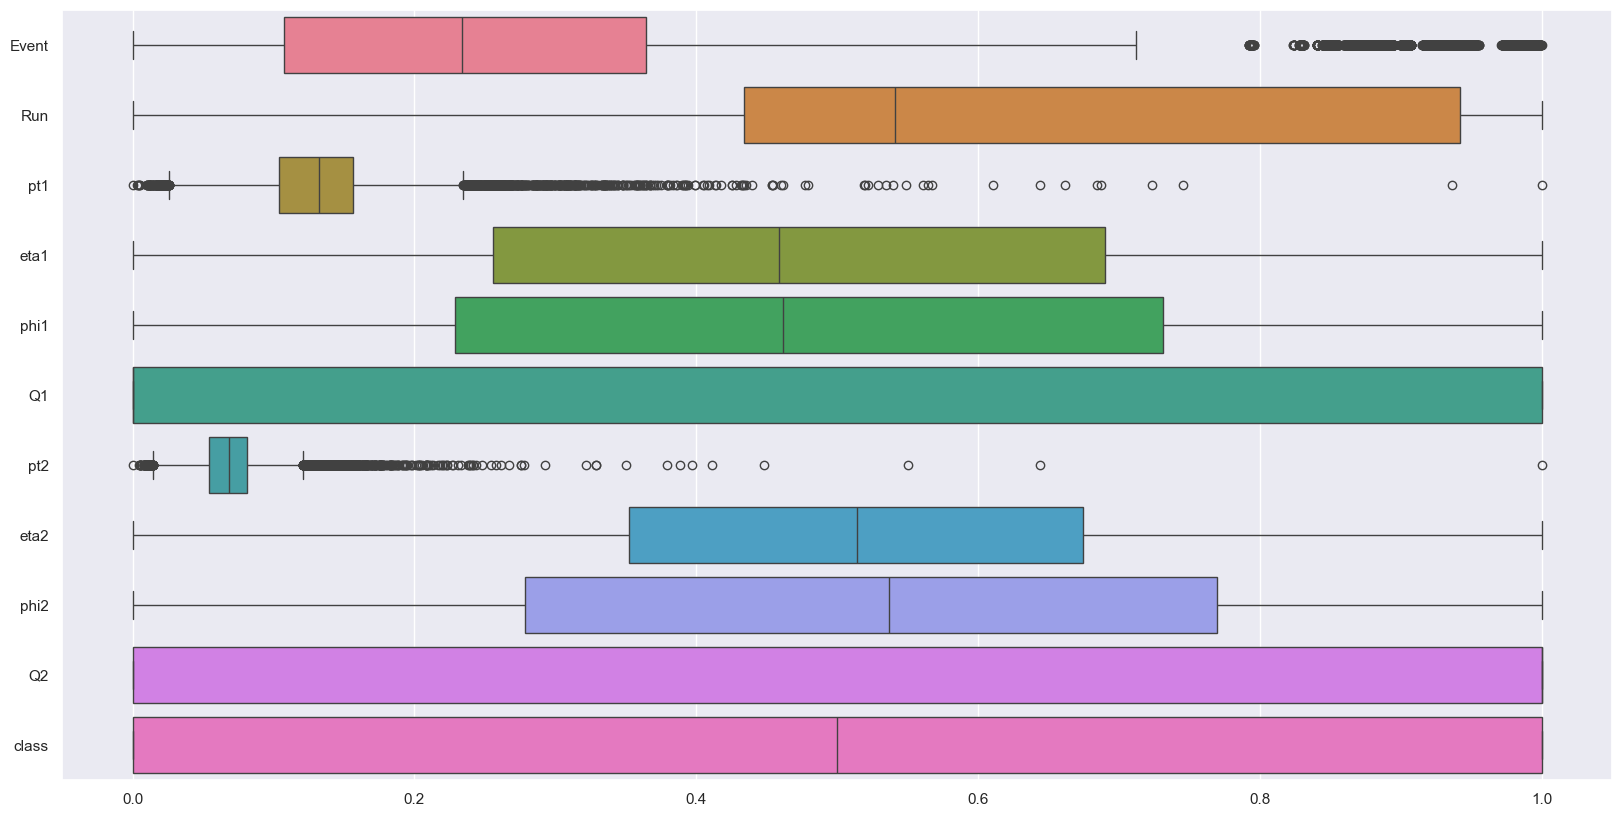

In [7]:
if data_checks=='y':
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_raw) # normalization
    df_array_to_df = pd.DataFrame(df_scaled, columns = df_raw.columns) # convert array into dataframe
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    sns.boxplot(data=df_array_to_df, orient="h")

**Boxplot comment**: `pt1`, and `pt2` are features exhibiting outliers.

The skewness is a measure of symmetry or asymmetry of data distribution. Data can be positive-skewed (data-pushed towards the right side) or negative-skewed (data-pushed towards the left side). For pt1, the skewness is between -0.5 & 0.5, so the data are nearly symmetrical. But, for pt2, the skewness is greater than 1 (positive skewed), so the data are extremely skewed. When data is skewed, the tail region may behave as an outlier for the statistical model, and outliers unsympathetically affect the model’s performance. Some statistical models are hard to outliers like Tree-based models, but it will limit the possibility of trying other models. So there is a necessity to transform the skewed data to be close enough to a Normal distribution.

In [6]:
if data_checks=='y':
    # visualization of skewness and kurtosis for the features that present outliers
    f, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    sns.histplot(df_raw.iloc[:,0], color="skyblue", kde=True, ax=axes[0], bins=80)
    sns.histplot(df_raw.iloc[:,3], color="olive", kde=True, ax=axes[1], bins=80) 
    
    axes[0].text(x=0.97, y=0.97, transform=axes[0].transAxes, s="Skewness: %f" % df_raw.iloc[:,0].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    axes[0].text(x=0.97, y=0.91, transform=axes[0].transAxes, s="Kurtosis: %f" % df_raw.iloc[:,0].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
    axes[1].text(x=0.97, y=0.97, transform=axes[1].transAxes, s="Skewness: %f" % df_raw.iloc[:,3].skew(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:poo brown')
    axes[1].text(x=0.97, y=0.91, transform=axes[1].transAxes, s="Kurtosis: %f" % df_raw.iloc[:,3].kurt(),\
        fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
        backgroundcolor='white', color='xkcd:dried blood')
    plt.tight_layout()

<Figure size 2000x1000 with 0 Axes>

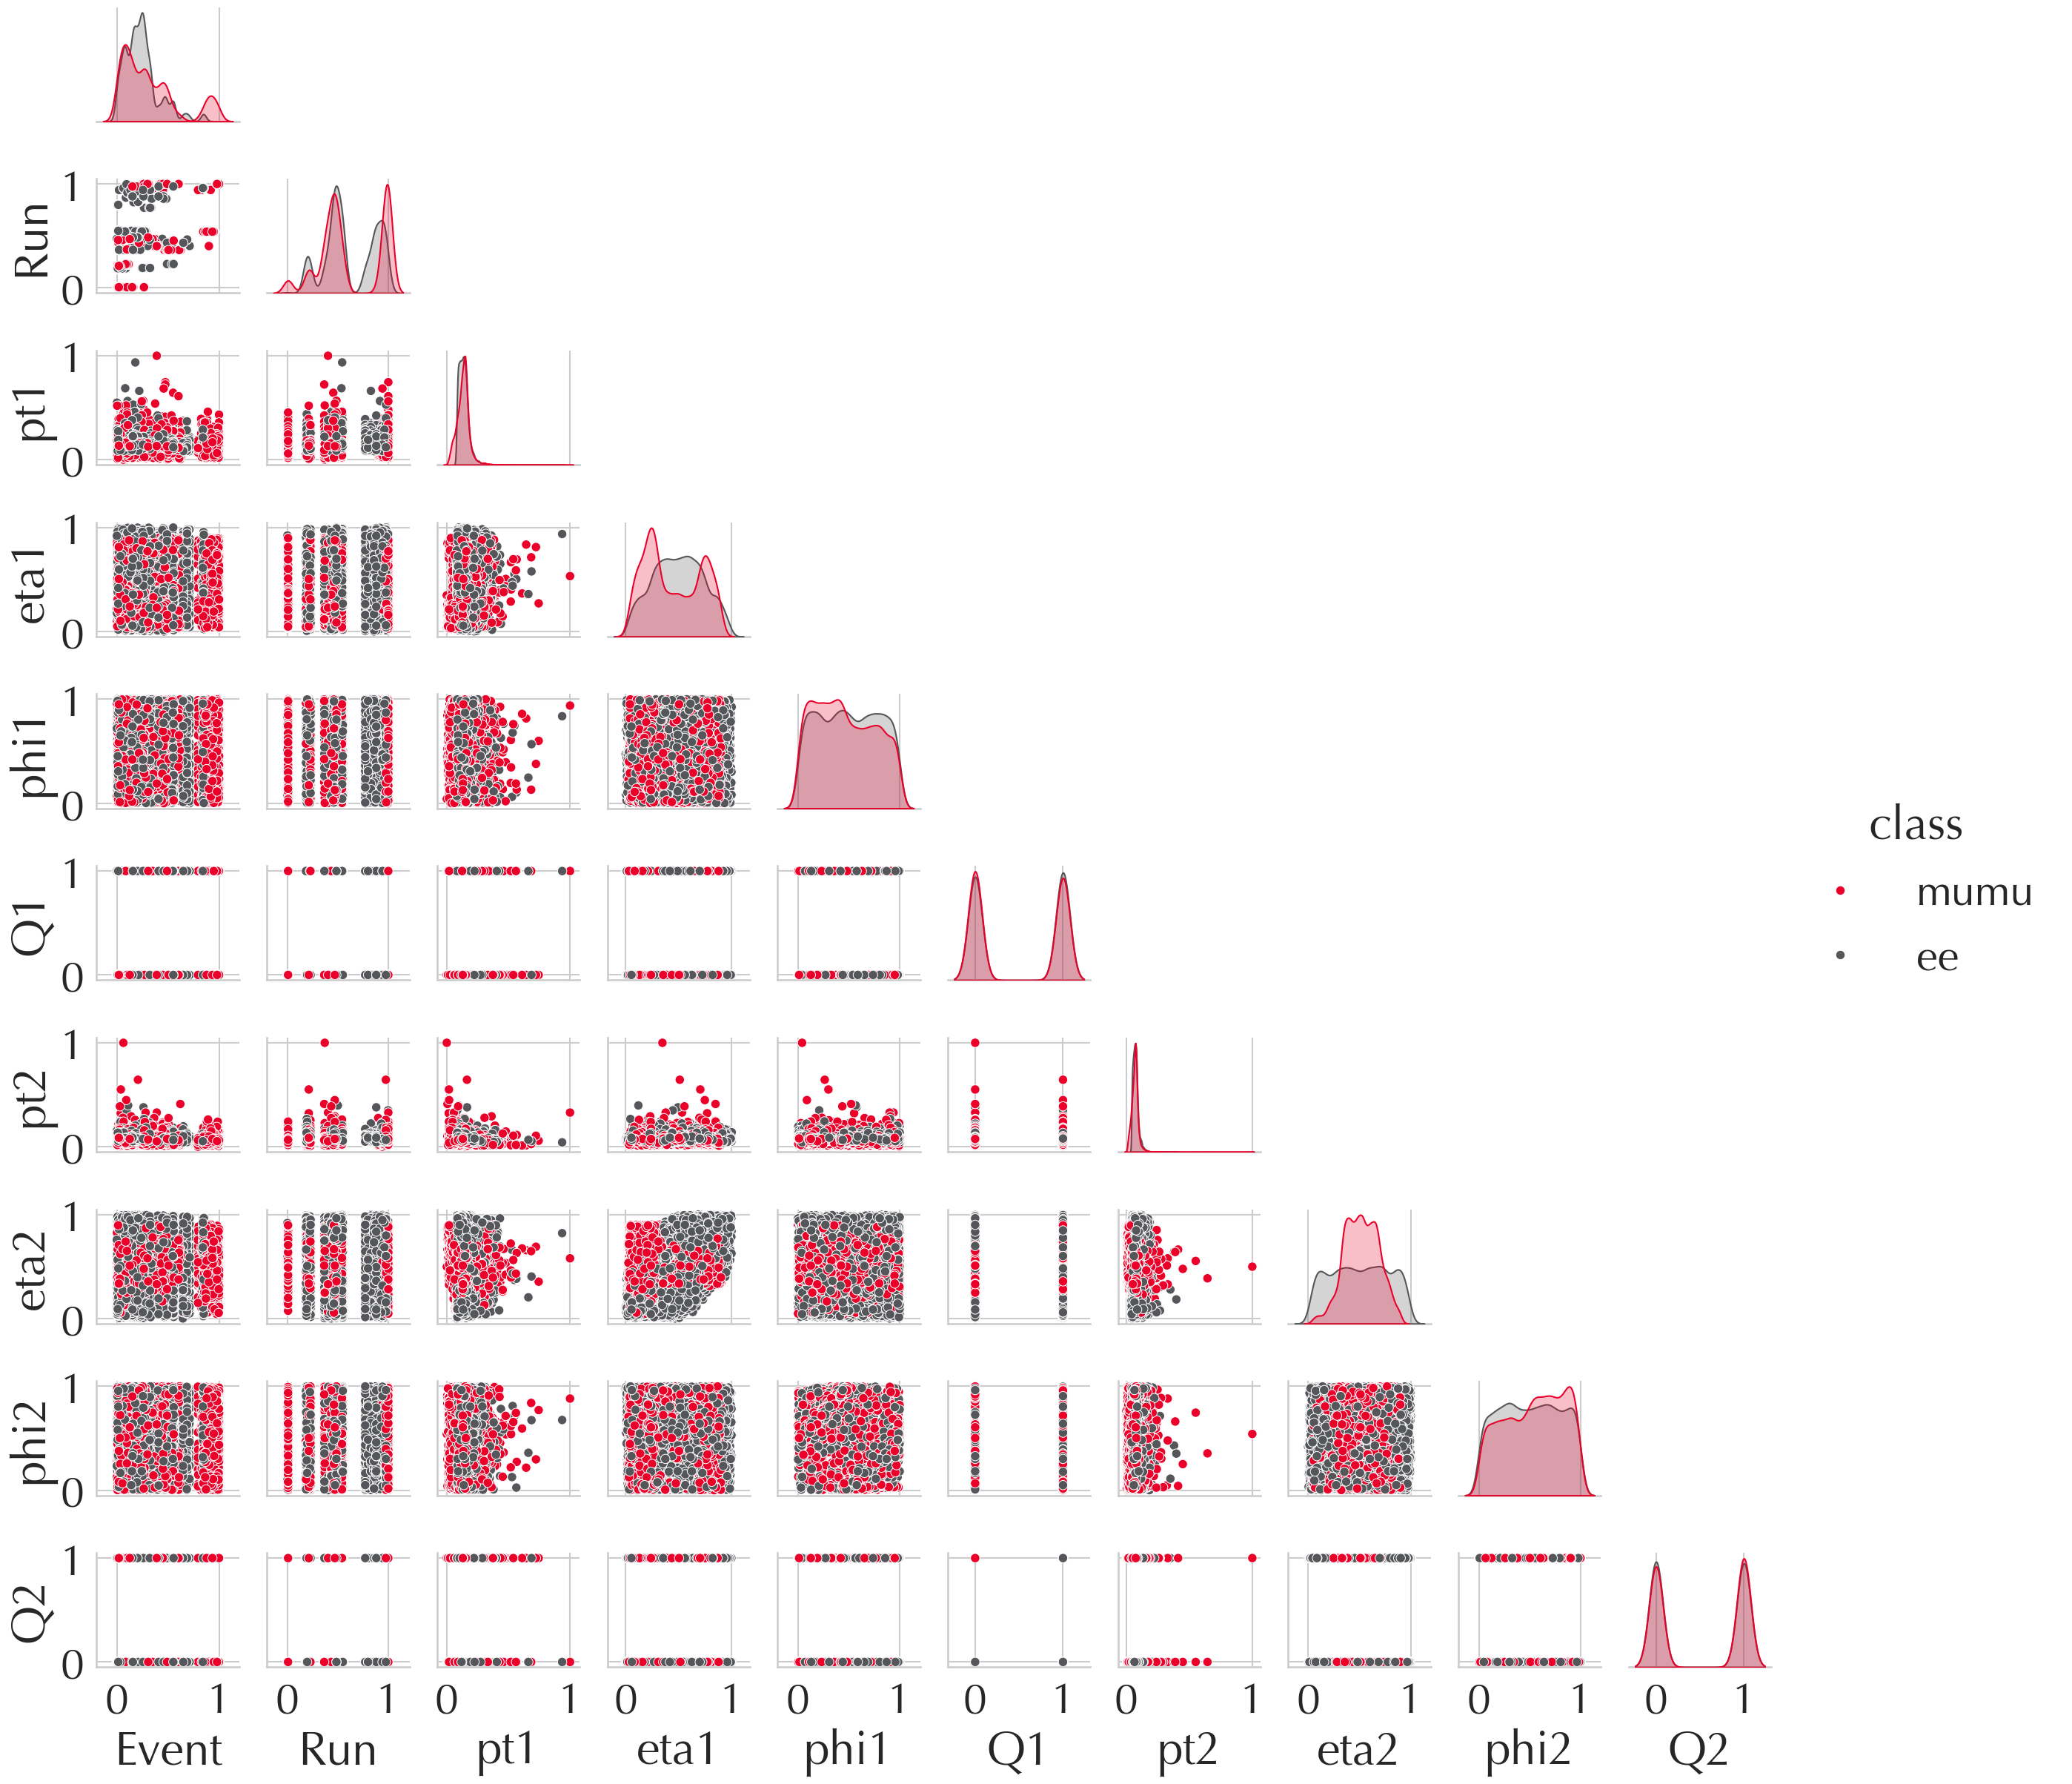

In [21]:
if data_checks=='y':
    df_array_to_df['class'] = df_array_to_df['class'].map({0:'ee', 1:'mumu'})
    sns.set_style('whitegrid', {'font.family':'Optima'})
    sns.set_context('talk', font_scale=2.5)
    font = {'family' : 'Optima'}
    plt.figure(figsize=(20, 10))
    fig_pairplot_scaled = sns.pairplot(df_array_to_df, hue="class", corner=True, palette=unitopalette)
    sns.move_legend(fig_pairplot_scaled, 'center right') # nn serve a nulla

In [22]:
fig_pairplot_scaled.savefig('./Zmodels/Zpairplot_scaled.pdf', bbox_inches='tight')
fig_pairplot_scaled.savefig('./Zmodels/Zpairplot_scaled.png', bbox_inches='tight')

## Preprocessing

In [8]:
df = df_raw

In [9]:
# This technique doesn't remove outliers but applies a different treatment: 
# like squishing the right tail to make the distribution closer to Normal 
# I think as long the transformation is monotonous there's no problem
if with_log:
    df["log(pt1)"] = df.pt1.apply(np.log1p)
    df["log(pt2)"] = df.pt2.apply(np.log1p) 
    df = df.drop(['pt1', 'pt2'], axis=1)  
df.head()

,Event,Run,eta1,phi1,Q1,eta2,phi2,Q2,class,log(pt1),log(pt2)
0,20257329,166784,-1.3248,-3.0057,-1,-0.6624,0.3485,1,1,3.782210,3.767915
1,64679856,163261,-0.0057,-0.7744,-1,1.3710,2.2952,1,0,3.710504,3.621663
2,196860468,165570,-0.4162,0.9198,1,-0.2680,-1.4629,1,0,4.303113,3.702314
3,497791581,172163,0.3063,-1.6034,1,-1.6182,1.5315,-1,0,3.539323,3.340722
4,550966077,173692,0.4276,-0.3876,-1,-0.3080,2.8965,1,1,3.806276,3.427047


In [10]:
del df_raw # cleanup

## Visualization

<Axes: xlabel='class', ylabel='count'>

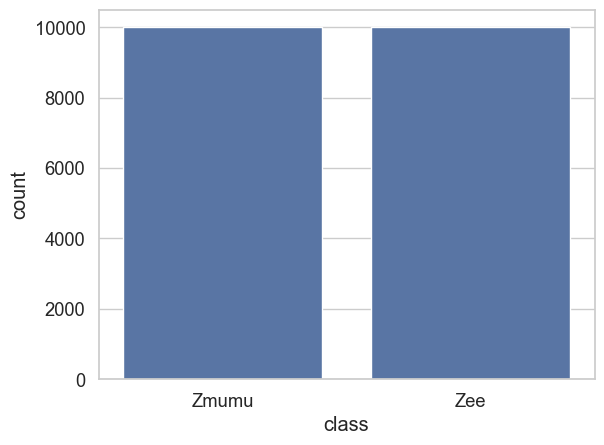

In [11]:
sns.set(font_scale=1.2)
sns.set_style('whitegrid')

df1 = df.copy()
df1['class'] = df1['class'].map({0: 'Zee', 1: 'Zmumu'})
sns.countplot(data=df1, x="class")

In [12]:
# Data scaled visualization
if data_checks=='y':
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df) # normalization
    df_array_to_df = pd.DataFrame(df_scaled, columns = df.columns) # convert array into dataframe
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    sns.boxplot(data=df_array_to_df, orient="h")

In [13]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    sns.set(font_scale=1.0)
    sns.heatmap(df.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

In [14]:
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    ax_pairplot = sns.pairplot(df1, hue="class")
    plt.setp(ax_pairplot.get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax_pairplot.get_legend().get_title(), fontsize='32') # for legend title 

**Pairplot**: by default, this function will create a grid of Axes such that each numeric variable in df1 will by shared across the y-axes across a single row and the x-axes across a single column. The diagonal plots are treated differently: a univariate distribution plot (ie 1 distrib di 1 sola variabile, a cui puntano riga e col) is drawn (per ciascuna dle 2 eventi ie Zmumu e Zee) to show the marginal distribution (ie le curve blu sono le distrib marginali dl'evento Zee, o Zmumu porta pazienza) of the data in each column. source : [seaborn.pairplot](https://seaborn.pydata.org/generated/seaborn.pairplot.html)

In [15]:
if data_checks=='y':
    #fig_pairplot.savefig('Zpairplot.pdf')
    fig_pairplot.savefig('Zpairplot.png')

# Dataset splitting

**First of all, I split the DataFrame into X (data) and Y (label), where:**

In [16]:
X = df.drop(['class'], axis=1) 
y = df['class']  

**Using a train-test split, I split X and Y into train and test data.**



*   Train Dataset: Used to fit model.
*   Test Dataset: Used to evaluate the fit model.



In [17]:
# Removing test data from training
X_others, X_test, y_others, y_test = train_test_split(X, y, test_size=0.20, random_state=None) # this outputs pandas

# train-validation split
X_train, X_validation, y_train, y_validation = train_test_split(X_others, y_others, test_size=0.20, random_state=0) # this outputs pandas

In [18]:
X_train.head()

,Event,Run,eta1,phi1,Q1,eta2,phi2,Q2,log(pt1),log(pt2)
7488,85582710,166967,-1.8288,-0.9439,-1,-1.6648,2.1784,1,3.545249,3.433535
10376,450826984,166033,-1.5429,-0.1352,-1,-0.3356,2.9182,1,3.539489,3.815589
2621,188523640,173381,1.7208,-1.2716,-1,1.0229,1.9600,1,3.962893,3.851808
3209,78007735,173198,-0.1301,1.5902,-1,1.1185,-1.5732,1,3.517611,3.830399
16342,191439363,166049,0.2445,0.1126,-1,1.7515,-2.9419,-1,3.788899,3.744886


# Feature scaling

In [19]:
X_train_scaled = tf.keras.layers.Normalization(axis=-1) # here we're defining a generical normalization layer
X_train_scaled.adapt(tf.convert_to_tensor(X_train)) # here we're informing the layer about mean and variances of each feature

**Building a simple neural network model**

*   **Optimizer**: These are certain algorithms that are used to change the attributes of the neural network to decrease the loss rate.
*   **Loss**: This is used to compute the quantity that a model should seek to minimize during training.


*   **Metrics**: This is used to judge the performance of the model.

# The MODEL
**Hyperparameters** setup!

In [20]:
nepochs = 600
batch_size=100

choosen_optimizer = 'adam'
choosen_loss = 'sparse_categorical_crossentropy'
activation = 'relu'

nodes = [64, 64]

In [21]:
fig_name = './Zmodels/Z'
for n in nodes:
    fig_name += f"{n}_"
fig_name += f"{choosen_optimizer}_{activation}"
fig_name

'./Zmodels/Z64_64_adam_relu'

In [22]:
def my_modelZ():
  model = tf.keras.Sequential([
    X_train_scaled,
    tf.keras.layers.Dense(nodes[0], activation=activation),
    tf.keras.layers.Dense(nodes[1], activation=activation),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax) 
  ])

  model.compile(optimizer=choosen_optimizer,
                loss=choosen_loss,
                metrics=['accuracy'])
  return model
    
model = my_modelZ()

In [23]:
history = model.fit(X_train, y_train, epochs=nepochs, validation_data=(X_validation, y_validation), batch_size=batch_size)

Epoch 1/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6268 - loss: 0.6241 - val_accuracy: 0.7419 - val_loss: 0.5081
Epoch 2/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.7650 - loss: 0.4809 - val_accuracy: 0.7891 - val_loss: 0.4343
Epoch 3/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.7847 - loss: 0.4358 - val_accuracy: 0.8022 - val_loss: 0.4114
Epoch 4/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.8097 - loss: 0.4031 - val_accuracy: 0.8078 - val_loss: 0.3975
Epoch 5/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.8173 - loss: 0.3911 - val_accuracy: 0.8253 - val_loss: 0.3800
Epoch 6/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8269 - loss: 0.3772 - val_accuracy: 0.8297 - val_loss: 0.3674
Epoch 7/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.8379 - loss: 0.3544 - val_accuracy: 0.8388 - val_loss: 0.3523
Epoch 8/600
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8469 - loss: 0.3

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (100, 10)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (100, 64)              │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (100, 64)              │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (100, 2)               │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,005 (58.62 KB)

 Trainable params: 4,994 (19.51 KB)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 9,990 (39.03 KB)

# Evaluating the model

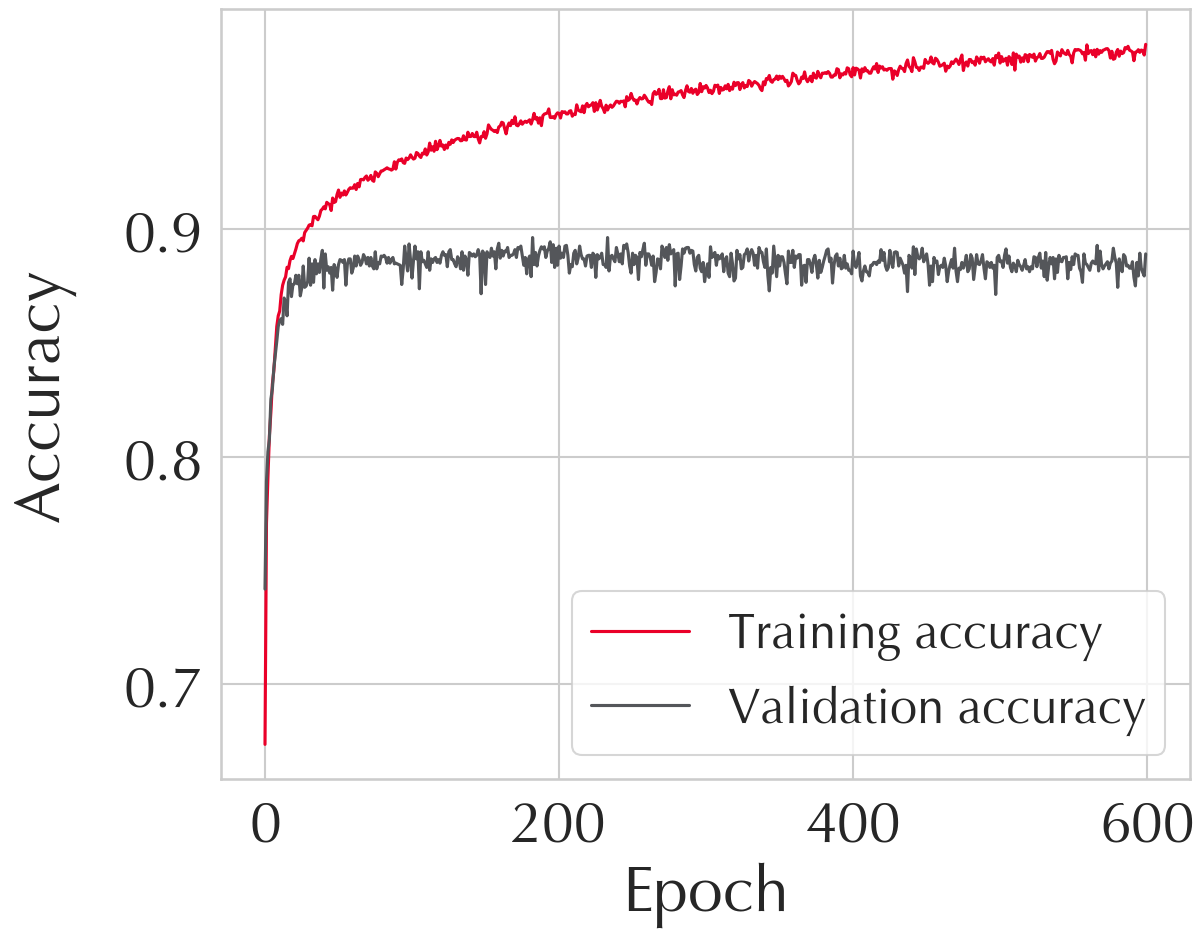

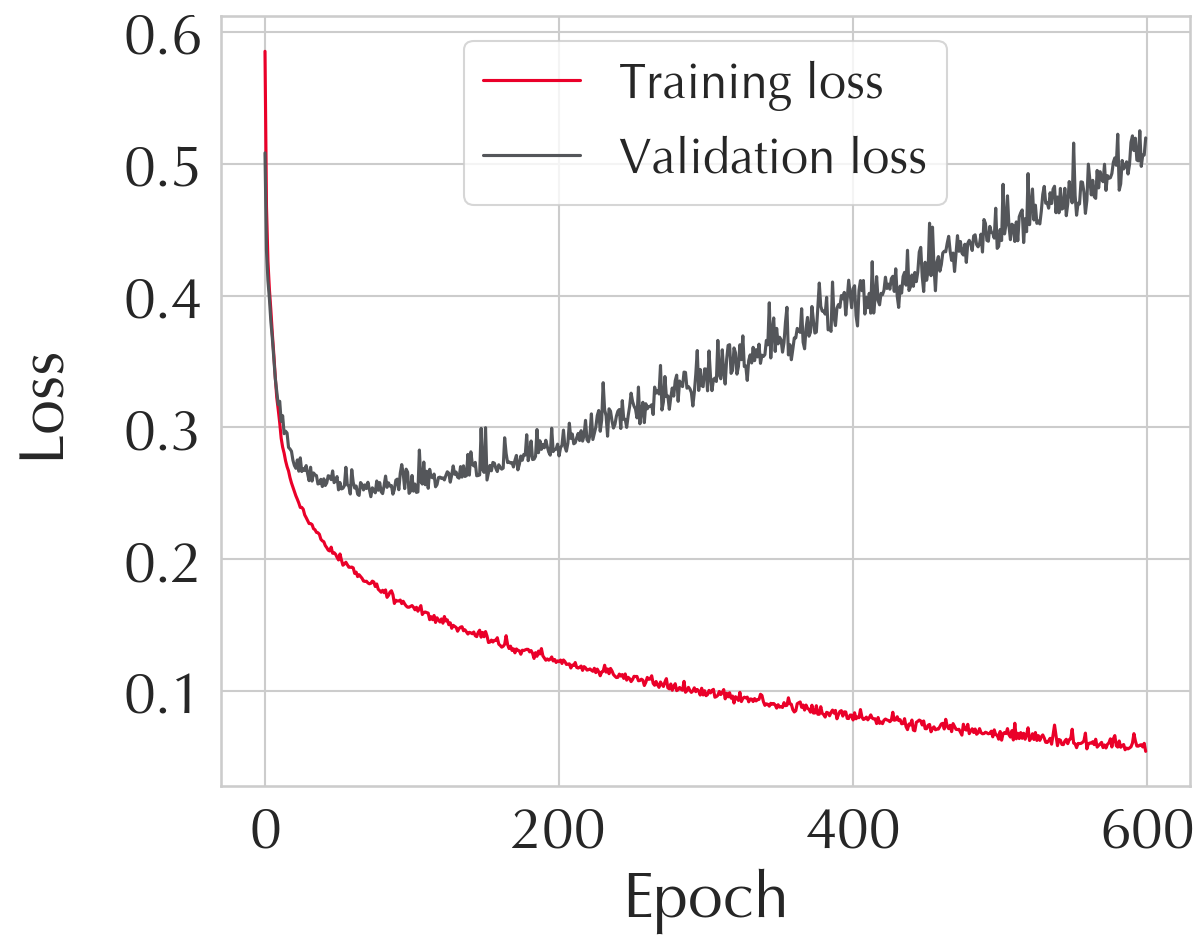

In [31]:
sns.set_style('whitegrid')#, {"font.family":['Optima']})
sns.set_context('talk', font_scale=2.5)

font = {'family' : 'Optima'}#,
#       'weight' : 'bold',
#       'size'   : 18}

unitocolor = '#EA0029'
unitogray  = '#54565A'
faircolor  = '#FDBB63'

plt.rc('font', **font)

fig_acc_curve, ax1  = plt.subplots(figsize=(12.5,10))
fig_rock_curve, ax2 = plt.subplots(figsize=(12.5,10))

#fig = plt.figure(figsize=(25,10))
#ax1 = plt.subplot(121)
#ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy', color=unitocolor)
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy', color=unitogray) 
#ax1.set_title("Training and validation accuracy")
ax1.yaxis.set_label_coords(-.15,.5)
ax1.set(xlabel='Epoch', ylabel='Accuracy')

ax2.plot(history.history['loss'], label='Training loss', color=unitocolor)
ax2.plot(history.history['val_loss'], label='Validation loss', color=unitogray)
ax2.yaxis.set_label_coords(-.15,.5)
#ax2.set_title("Training and validation loss")
ax2.set(xlabel='Epoch', ylabel='Loss')
#ax2.set_yscale('log')

# Testing
#test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
#ax1.plot(nepochs, test_acc, 'D', label="Test data evaluation", markersize=18, color=faircolor)
#ax2.plot(nepochs, test_loss, 'D', label="Test data evaluation", markersize=18, color=faircolor)

# Draw legend
ax1.legend(loc='lower right', fontsize=35)
ax2.legend(loc='upper center', fontsize=35)

In [32]:
fig_rock_curve.savefig(fig_name+'_rock.pdf', bbox_inches='tight')
fig_acc_curve.savefig(fig_name+'_acc.pdf', bbox_inches='tight')
#fig_rock_curve.savefig(fig_name+'.png')